In [1]:
%load_ext autoreload
%autoreload 2

import datetime

import numpy as np
import pandas as pd
import gudhi

from traffic.core import Traffic, Flight
from functions.data_filtering import ICAO_codes, large_gap_filter
from functions.data_processing import flight_persistence, sublevelset_persistence, remove_outliers_z_score, remove_outliers_dbscan
from functions.data_loading import linkage_cluster_persistances, flights_from_query, get_landing_labels, get_flight_persistances

from scipy.cluster.hierarchy import fcluster
from matplotlib import pyplot as plt

In [11]:
# load minimum data set
df = pd.read_csv("data/go_arounds_augmented.csv", low_memory=False)
df["time"] = pd.to_datetime(df["time"])

start = datetime.datetime(year=2019, month=1, day=1).replace(
    tzinfo=datetime.timezone.utc
)
stop = datetime.datetime(year=2019, month=3, day=1).replace(
    tzinfo=datetime.timezone.utc
)

(array([5.096e+03, 1.000e+02, 5.700e+01, 3.500e+01, 1.000e+01, 1.000e+00,
        8.000e+00, 0.000e+00, 2.000e+00, 1.000e+00]),
 array([ 2. ,  4.3,  6.6,  8.9, 11.2, 13.5, 15.8, 18.1, 20.4, 22.7, 25. ]),
 <BarContainer object of 10 artists>)

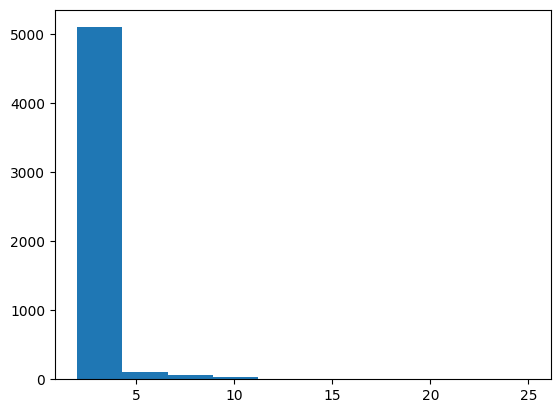

In [12]:
with_GA = df.query(f"has_ga & (@start <= time <= @stop)")
without_GA = df.query(f"not has_ga & (@start <= time <= @stop)")

plt.hist(with_GA["n_approaches"])

In [13]:
without_GA = without_GA.sample(n=with_GA.shape[0], random_state=42)
query = pd.concat([with_GA, without_GA], axis=0)

In [15]:
file_name = "balanced1_2"
flights = flights_from_query(query, file_name, load_results=True)
data = get_landing_labels(query, file_name, load_results=True)

 13%|█▎        | 1425/10620 [00:21<02:19, 65.75it/s]


ValueError: polyorder must be less than window_length.

In [16]:
approach_1 = df.query(f"n_approaches==1 & (@start <= time <= @stop)")
approach_2 = df.query(f"n_approaches==2 & (@start <= time <= @stop)")
approach_3 = df.query(f"n_approaches==3 & (@start <= time <= @stop)")
approach_4 = df.query(f"n_approaches==4 & (@start <= time <= @stop)")

count_4 = approach_4.shape[0]
count_3 = min(approach_3.shape[0], count_4*2)
count_2 = min(approach_2.shape[0], count_3*2)
count_1 = min(approach_1.shape[0], count_2*2)

approach_3 = approach_3.sample(n=count_3, random_state=42)
approach_2 = approach_2.sample(n=count_2, random_state=42)
approach_1 = approach_1.sample(n=count_1, random_state=42)
query = pd.concat([approach_1, approach_2, approach_3, approach_4], axis=0)

In [18]:
file_name = "unbalanced1_2_3_4"
flights = flights_from_query(query, file_name, load_results=True)
data = get_landing_labels(query, file_name, load_results=True)

  2%|▏         | 30/1215 [00:00<00:11, 103.86it/s]


ValueError: polyorder must be less than window_length.

In [19]:
approach_1 = df.query(f"n_approaches==1 & (@start <= time <= @stop)")
approach_2 = df.query(f"n_approaches==2 & (@start <= time <= @stop)")
approach_3 = df.query(f"n_approaches==3 & (@start <= time <= @stop)")

count = approach_3.shape[0]

approach_2 = approach_2.sample(n=count, random_state=42)
approach_1 = approach_1.sample(n=count, random_state=42)
query = pd.concat([approach_1, approach_2, approach_3], axis=0)

In [20]:
file_name = "balanced1_2_3"
flights = flights_from_query(query, file_name, load_results=True)
data = get_landing_labels(query, file_name, load_results=True)

  4%|▎         | 30/840 [00:00<00:07, 105.61it/s]


ValueError: polyorder must be less than window_length.

In [32]:
trees, paths = sublevelset_persistence(flights[:1000], "geoaltitude")

100%|██████████| 1000/1000 [00:06<00:00, 159.82it/s]


In [33]:
path = f"../../data/linkage_clustering/cyclic_dataset.pkl"
Z = linkage_cluster_persistances(trees, path=path, load_results=False)

100%|██████████| 1000/1000 [03:45<00:00,  4.43it/s]


In [34]:
clustering = fcluster(Z, t=10, criterion='maxclust')

for i in range(1, len(np.unique(clustering))+1):
    print(f"{i}: {sum(clustering == i)}")

1: 55
2: 12
3: 554
4: 345
5: 11
6: 6
7: 3
8: 1
9: 2
10: 11


In [38]:
from matplotlib import pyplot as plt

ind = 10

flight = flights[np.where(clustering == ind)[0][0]]
tree = trees[np.where(clustering == ind)[0][0]]
points = paths[np.where(clustering == ind)[0][0]]
before = flight.data[["geoaltitude"]].to_numpy()
before = np.column_stack((np.arange(len(data)), before))

dbscan_paths        = before[remove_outliers_dbscan(before, 25, eps = 0.05)]
z_score_paths       = before[remove_outliers_z_score(before)]

path_filters = [(before, "before"), (z_score_paths, "z-score"), (dbscan_paths, "dbscan")]

fig, axs = plt.subplots(3)#, sharex=True, sharey=True)
for i, (path, name) in enumerate(path_filters):
    axs[i].scatter(path[:, 0], path[:, 1])
    axs[i].set_title(name)

fig.set_figheight(10)
fig.set_figwidth(10)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 10620 and the array at index 1 has size 1800

In [8]:
gudhi.persistence_graphical_tools.plot_persistence_diagram(tree, axes=axs[1])
print(tree)

C:\Users\tobso\Desktop\programering\masters-thesis\venv\Lib\site-packages\gudhi\persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


AttributeError: 'numpy.ndarray' object has no attribute 'add_patch'

In [ ]:
fig = plt.scatter(points[:, 1], points[:, 0])
plt.show()